In [1]:
using Pkg
Pkg.activate(".")
using Revise


  Activating new environment at `/mnt/D/git_repos/PeriDyn/notebooks/Project.toml`


In [2]:
using PeriDyn
using PDMesh
using ForwardDiff
using Flux
# using GR
using Statistics
using Random

┌ Info: Precompiling PeriDyn [c3db0ce0-6d7e-41b5-be11-bcb6aafada44]
└ @ Base loading.jl:1342


In [33]:
resolution = 1.0
horizon = 3*resolution

x1, v1, y1, vol1, type1 = unpack(create(Cuboid([-3 13; 0 10; 0 10]), resolution=resolution))


mask1 = (y1[1, :] .> 10.0)

mask = (y1[1, :] .> 0.0) .& (y1[1, :] .< 10.0)

y1[1, mask] *= 1.1

mat_gen1 = GeneralMaterial(y1, v1, x1, vol1, type1, horizon; max_neigh=200)


Es = 100
nu = 0.2
K = Es/3/(1-2nu)
G = Es/2/(1+nu)
den = 1.0
cstretch = 1.0


mat_spec1 = OrdinaryStateBasedSpecific([K], [G], [cstretch], [den])
mat_spec2 = BondBasedSpecific([K], [cstretch], [den])

block1 = PeridynamicsMaterial(mat_gen1, mat_spec1)
block2 = PeridynamicsMaterial(mat_gen1, mat_spec2)


#

Average family members: 69.18


BondBasedMaterial("PM", 1:1, GeneralMaterial
type: [1]
horizon: 3.0
particle size: [1.0]
, BondBasedSpecific
bond_stiffness: [55.555555555555564]
critical_stretch: [1.0]
density: [1.0]
)

In [36]:
FF = force_density_T(1.1*y1, block1)

sum(FF[1, mask1])



3881.4042136857497

In [37]:
FF = force_density_T(1.1*y1, block2)

sum(FF[1, mask1])



24075.806238436075

In [5]:
mat_spec2 = PairwiseNNSpecific([2, 10, 1], [cstretch], [den]; act=tanh)
block2 = PeridynamicsMaterial(deepcopy(mat_gen1), mat_spec2)

PairwiseNNMaterial("PM", 1:1, GeneralMaterial
type: [1]
horizon: 3.0
particle size: [1.0]
, PairwiseNNSpecific
NNs: PeriDyn.SymMat(Any[Chain(Dense(2, 10, tanh), Dense(10, 1))], 1)
critical_stretch: [1.0]
density: [10000.0]
)

In [6]:
FF = force_density_T(1.1*y1, block2)

3×8 Matrix{Float64}:
 -0.207532   0.207532  -0.207532  …   0.207532  -0.207532  0.207532
 -0.207532  -0.207532   0.207532     -0.207532   0.207532  0.207532
 -0.207532  -0.207532  -0.207532      0.207532   0.207532  0.207532

In [24]:
# function ext_bl(y::Array{Float64,2}, mat::PairwiseNNMaterial)
#     types = mat.general.type
#     x = mat.general.x 
#     intact = mat.general.intact
#     family = mat.general.family
#     N = size(family, 2)
#     M = size(family, 1)
#     ARGS = map((i) -> (i, 1:M), 1:N)    

#     function with_if_cal_force_ij(i, k)
#         if intact[k,i]
#             j = family[k,i]
#             X = [x[1,j]-x[1,i],x[2,j]-x[2,i],x[3,j]-x[3,i]]
#             Y = [y[1,j]-y[1,i],y[2,j]-y[2,i],y[3,j]-y[3,i]]
#             _X = PeriDyn.get_magnitude(X)
#             _Y = PeriDyn.get_magnitude(Y)
#             ext = _Y - _X
#             s = ext/_X
#             type1 = types[i]- mat.type.start + 1
#             type2 = types[j] - mat.type.start + 1
#             if s < mat.specific.critical_stretch[type1, type2]
#                 return [ext, _X, ext/_X, block1.specific.bond_stiffness[type1, type2]*ext/_X]
#             else
#                 return [0.0, 0.0, 0.0, 0.0]
#             end            
#         else
#             return [0.0, 0.0, 0.0, 0.0]
#         end
#     end
    
#     inner_map(i, inds) = map((j)-> with_if_cal_force_ij(i,j), inds)
#     outer_map(ARGS) = map((x)->inner_map(x[1], x[2]), ARGS)

#     return hcat(outer_map(ARGS)...)
# end

    
# X = vcat(vec(ext_bl(1.1*y1, block2)), vec(ext_bl(0.9*y1, block2)))

In [9]:
particles = randperm(size(y1, 2))

8-element Vector{Int64}:
 7
 3
 2
 6
 8
 5
 1
 4

In [10]:
function loss(k, particles)
    mean((force_density_T(k*y1, block1; particles=particles) .- 
            force_density_T(k*y1, block2; particles=particles)).^2)
end

loss(1.0, particles)

0.0032936439127499964

In [26]:
Revise.retry()

refresh()

In [41]:
print(force_density_T(1.0*y1, block1; particles=particles))

gs = gradient(params(block2.specific.NNs[1])) do
    sum(force_density_T(1.0*y1, block1; particles=particles))
end


[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]

Grads(...)

In [111]:
using Zygote

function add!(a::Zygote.Grads, b::Zygote.Grads)
    for p in a.params
        a[p] .= a[p] .+ b[p]
    end
end

function div!(a::Zygote.Grads, i::T) where T <: Real
    for p in a.params
        a[p] ./= i
    end
    a
end

function mul!(a::Zygote.Grads, i::T) where T <: Real
    for p in a.params
        a[p] .*= i
    end
    a
end



mul! (generic function with 1 method)

In [112]:
theta = Flux.params(block2.specific.NNs[1])
grad_fn = (k, p) -> Flux.gradient(() -> loss(k, p), theta)
grad_fn(1.1, particles)

Grads(...)

In [113]:
grad_fn(1.0, particles)

Grads(...)

In [114]:
function batched(X; n=10)
    N = size(X)[1]
    s = fld(N, n)
    (X[1+(i-1)*s:i*s] for i in 1:n)
end

batched (generic function with 1 method)

In [115]:
opt = Flux.ADAM(0.01)

ADAM(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [ ]:
N = size(y1, 2)

for i in 1:1000
    if i%10==0
        particles = randperm(size(y1, 2))
        println("Epoch: $i\t\tLoss: $(loss(1.1, particles))")
    end
    
    particles = randperm(size(y1, 2))
    gs = grad_fn(0.9, particles)
    
    for k in 0.9:0.05:1.1
        particles = randperm(size(y1, 2))
        add!(gs, grad_fn(k, particles))
    end

    Flux.update!(opt, theta, div!(gs, 5))
end

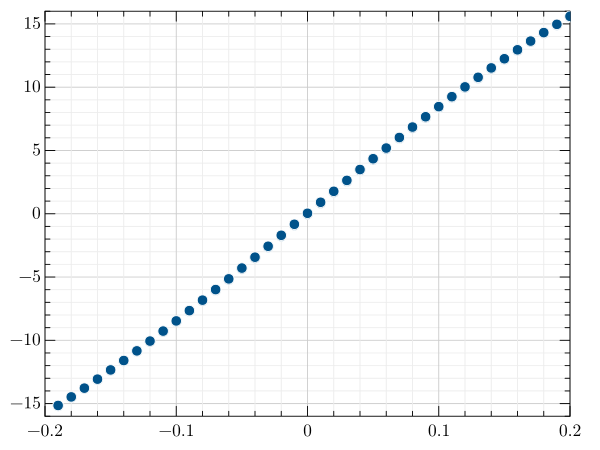

In [117]:
k = 2

X2 = vcat([[i, 1.0, i] for i in -0.1*k:0.01:0.1*k], [[i, 1.4, i] for i in -0.1*k:0.01:0.1*k])

pred = (x) -> [block2.specific.NNs[1](x[1:2])[1], x...]

XY = hcat(pred.(X2)...)

scatter(XY[4, :], XY[1, :])